In [13]:
import sys
sys.path.extend(['/home/quic/QUIC-Projects'])

import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
DATA_DIR = Path("/home/quic/QUIC-Projects/summary_ipynb/2022/06 June/02 Thu/circuits_benchmarking")
OBJ_FUNC = r'$\mathcal{L}_{\phi, \lambda}$'

In [14]:
plt.style.use('./styles/figstyle.mplstyle')
plt.style.reload_library()

In [15]:
from pandas import read_csv, DataFrame
data = read_csv(DATA_DIR/'sample_summary.csv')

training_data = np.load(DATA_DIR/'Dataset #0/training_data.npy')
test_data = np.load(DATA_DIR/'Dataset #0/test_data.npy')
training_label = np.load(DATA_DIR/'Dataset #0/training_label.npy')
test_label = np.load(DATA_DIR/'Dataset #0/test_label.npy')

In [16]:
import dill
import json

with open(DATA_DIR/"setting.json", 'r') as fp:
    _setting = json.load(fp)
_setting_save = _setting["Saving results"]
_setting_data = _setting["Data set selection"]
_setting_qasvm = _setting["SoftQASVM setting"]
_setting_simulator = _setting["Simulator setting"]
_setting_optimizer = _setting["Optimizer setting"]
_setting_rep = _setting["Repetition setting"]

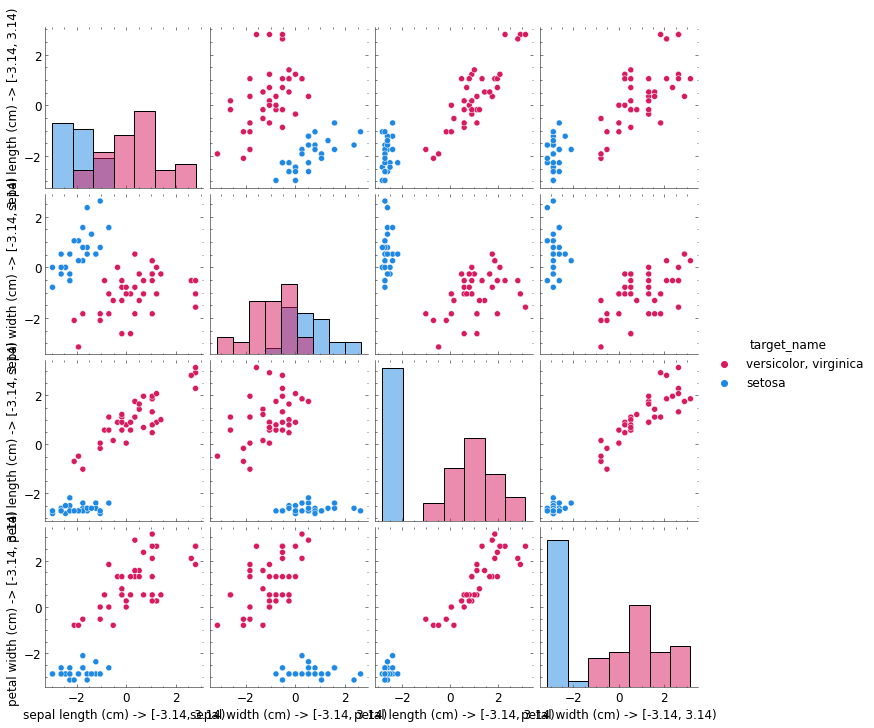

In [17]:
from classifiers.datasets import SklearnDataset

with plt.rc_context({'figure.figsize':(5, 5)}):
    ds = SklearnDataset('iris', (-np.pi, np.pi), true_hot=_setting_data['DATA_HOT'])
    ax = ds.plot(ds.sample_training_and_test_dataset((len(training_label), len(test_label)), return_X_y=False, random_state=_setting_rep["SEED"])[0])

In [18]:
C = _setting_qasvm["C"]
lamda = _setting_qasvm["LAMBDA"]

In [19]:
def fval(did, cid, layer, reps):
    with open(DATA_DIR/f"Dataset #{did}/Circuit #{cid}/layer={layer}/{reps}/test_result.json", 'r') as fp:
        f = np.array(json.load(fp)['f'])
    return f

with open(DATA_DIR/f"Dataset #{0}/Circuit #{1}/layer={1}/{0}/qasvm", 'rb') as fp:
    _qasvm = dill.load(fp)

training_kernel = _qasvm.kernel_matrix
test_kernel = _qasvm._qk.evaluate(test_data, training_data)

In [20]:
from classifiers.convex.svm import CvxSoftQASVM

svm = CvxSoftQASVM(kernel='precomputed', C=C, lamda=lamda)
svm.fit(training_kernel, training_label)
true_f = svm.f(test_kernel)

In [21]:
def fval_error(*args):
    return np.mean(np.abs(fval(*args)-true_f))# /sum(np.abs(true_f))

from itertools import product
from pandas import DataFrame

fval_error_ = {}
for _ind, _exp in enumerate(data.iloc):
    fval_error_[_ind] = fval_error(int(_exp['dataset']), int(_exp['circuit_id']), int(_exp['layer']), 0)
new_data = data.to_dict()
new_data['ferror'] = fval_error_
data = DataFrame(new_data)

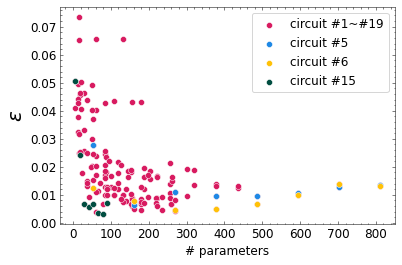

In [22]:
import seaborn as sns

sns.scatterplot(data=data, x='num_params', y='ferror', label='circuit #1~#19')
sns.scatterplot(data=data.loc[data['circuit_id']==5], x='num_params', y='ferror', label='circuit #5')
sns.scatterplot(data=data.loc[data['circuit_id']==6], x='num_params', y='ferror', label='circuit #6')
sns.scatterplot(data=data.loc[data['circuit_id']==15], x='num_params', y='ferror', label='circuit #15')

# plt.xscale('log')
plt.xlabel('# parameters')
plt.ylabel(r'$\epsilon$', fontsize=20)
plt.legend()
plt.savefig(f'./figs/si_sum_epsilon_num_params({_setting_data["TRAINING_SIZE"]}).pdf')

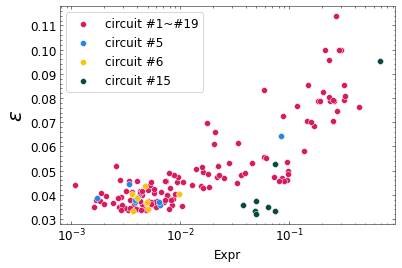

In [23]:
import seaborn as sns

plt.figure()
sns.scatterplot(data=data, x='expr', y='last_cost_avg', label='circuit #1~#19')
sns.scatterplot(data=data.loc[data['circuit_id']==5], x='expr', y='last_cost_avg', label='circuit #5')
sns.scatterplot(data=data.loc[data['circuit_id']==6], x='expr', y='last_cost_avg', label='circuit #6')
sns.scatterplot(data=data.loc[data['circuit_id']==15], x='expr', y='last_cost_avg', label='circuit #15')

plt.xscale('log')
plt.xlabel('Expr')
plt.ylabel(r'$\epsilon$', fontsize=20)
plt.legend()
plt.savefig(f'./figs/si_sum_epsilon_expr({_setting_data["TRAINING_SIZE"]}).pdf')

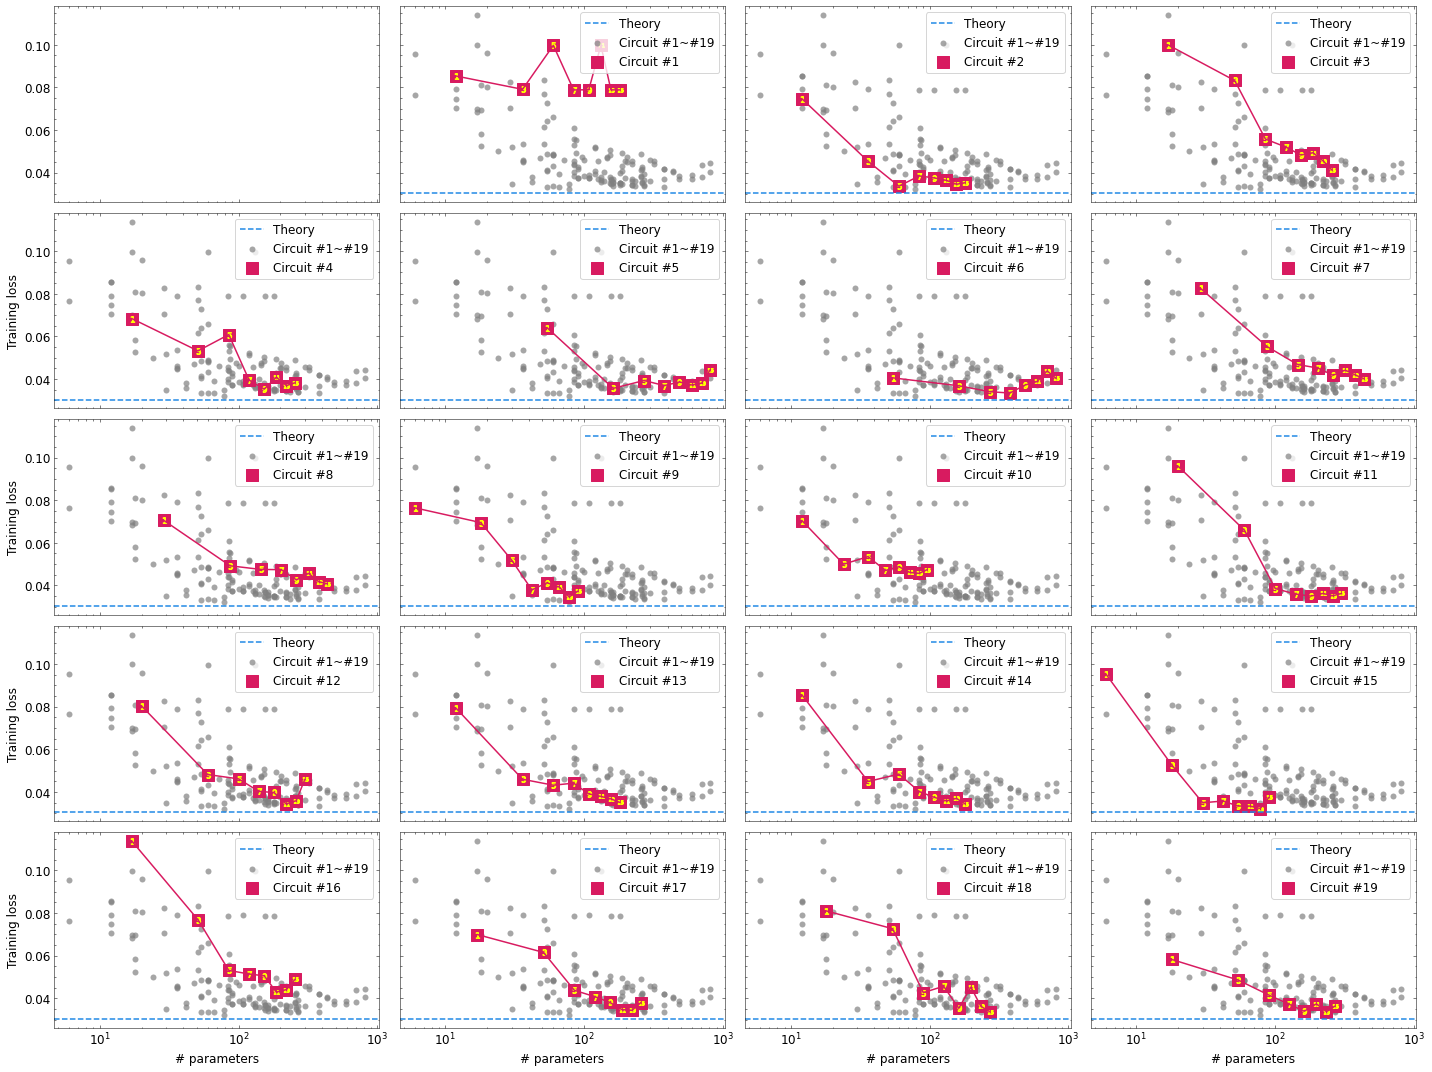

In [24]:
%matplotlib inline
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(5, 4, figsize=(20, 15), squeeze=True, sharex=True, sharey=True)
for cid in _setting_qasvm["CIRCUIT_ID"]:
    ax = axes.flatten()[cid%20]
    not15 = data.loc[data['circuit_id']!=cid]
    yes15 = data.loc[data['circuit_id']==cid]
    ax.scatter(not15['num_params'], not15['last_cost_avg'], marker='o', color='grey', alpha=0.7, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
    ax.plot(yes15['num_params'], yes15['last_cost_avg'], marker='', color=colors[0])
    if cid<20:
        with plt.rc_context({'lines.markersize': 2*plt.rcParams['lines.markersize']}):
            ax.scatter(yes15['num_params'], yes15['last_cost_avg'], marker='s', color=colors[0], label=f'Circuit #{cid}')
        for l in _setting_qasvm["LAYERS"]:
            ax.scatter(yes15.loc[yes15['layer']==l]['num_params'], yes15.loc[yes15['layer']==l]['last_cost_avg'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
    ax.axhline(y=svm.dual_objective_value, linestyle='--', label='Theory', color=colors[1])
    ax.set_xscale('log')
    if cid%20 in [0, 4, 8, 12, 16]:
        ax.set_ylabel('Training loss')
    if cid%20 in [16, 17, 18, 19]:
        ax.set_xlabel('# parameters')
    ax.legend()
plt.tight_layout()
plt.savefig(f'./figs/si_num_param_vs_cost({_setting_data["TRAINING_SIZE"]}).pdf')
plt.show()

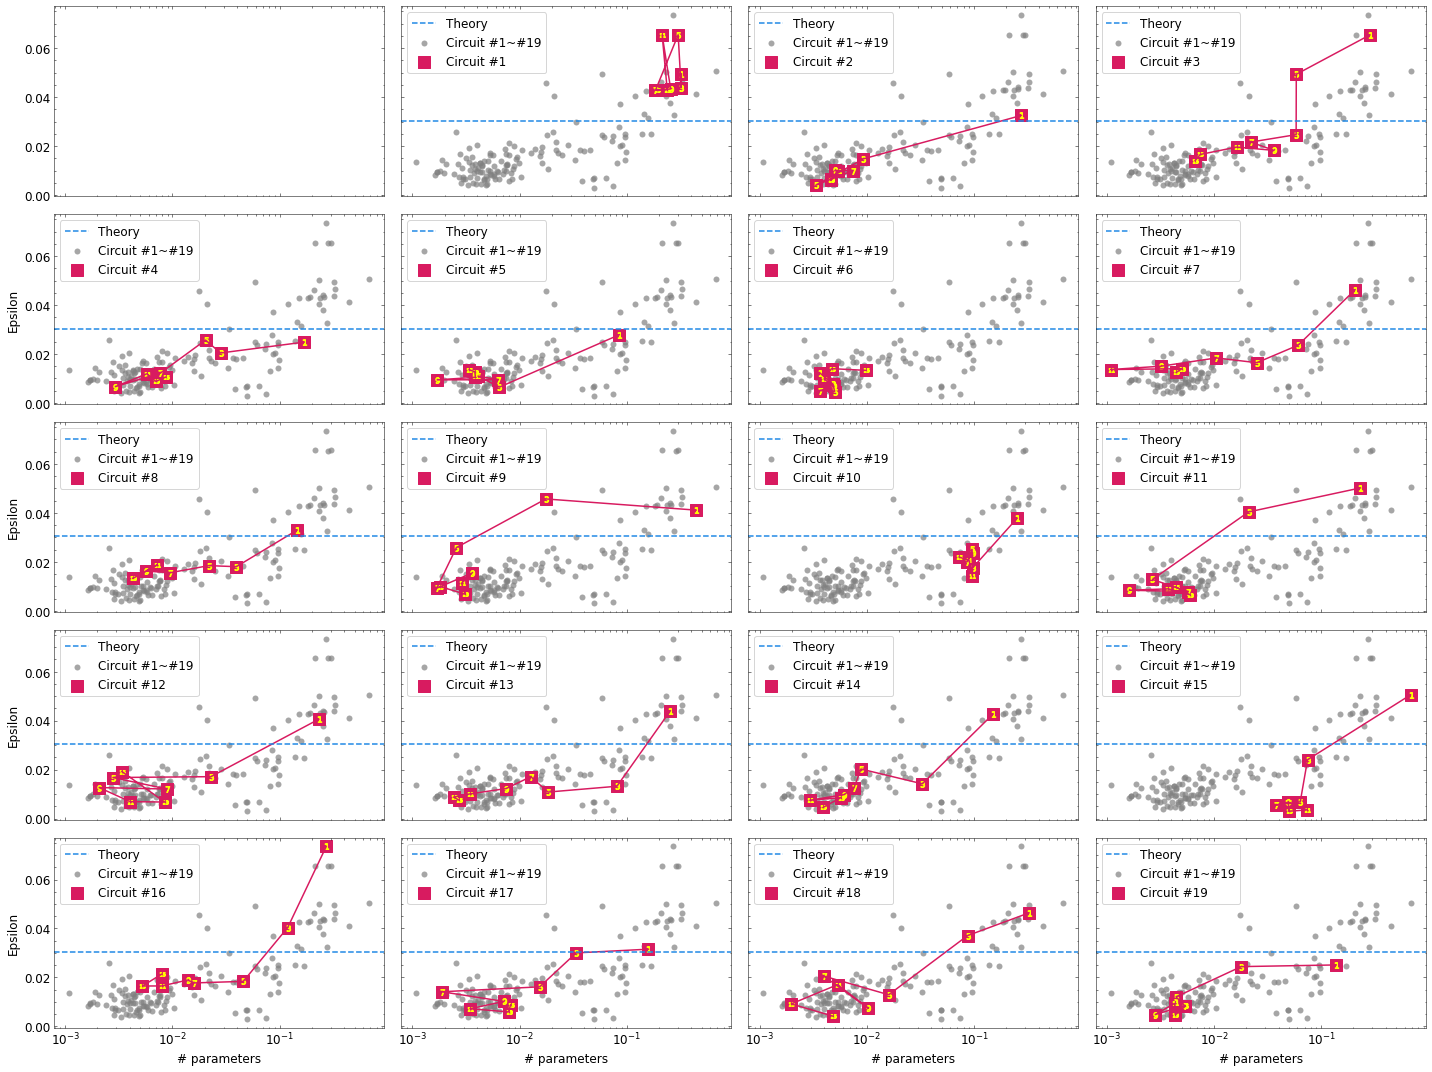

In [26]:
%matplotlib inline
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(5, 4, figsize=(20, 15), squeeze=True, sharex=True, sharey=True)
for cid in _setting_qasvm["CIRCUIT_ID"]:
    ax = axes.flatten()[cid%20]
    not15 = data.loc[data['circuit_id']!=cid]
    yes15 = data.loc[data['circuit_id']==cid]
    ax.scatter(not15['expr'], not15['ferror'], marker='o', color='grey', alpha=0.7, linewidth=0, label='Circuit #1~#19')#yerr=std_result['num_iter'])
    ax.plot(yes15['expr'], yes15['ferror'], marker='', color=colors[0])
    if cid<20:
        with plt.rc_context({'lines.markersize': 2*plt.rcParams['lines.markersize']}):
            ax.scatter(yes15['expr'], yes15['ferror'], marker='s', color=colors[0], label=f'Circuit #{cid}')
        for l in _setting_qasvm["LAYERS"]:
            ax.scatter(yes15.loc[yes15['layer']==l]['expr'], yes15.loc[yes15['layer']==l]['ferror'], marker=f'${l}$', color='yellow')#yerr=std_result['num_iter'])
    ax.axhline(y=svm.dual_objective_value, linestyle='--', label='Theory', color=colors[1])
    ax.set_xscale('log')
    if cid%20 in [0, 4, 8, 12, 16]:
        ax.set_ylabel('Epsilon')
    if cid%20 in [16, 17, 18, 19]:
        ax.set_xlabel('# parameters')
    ax.legend()
plt.tight_layout()
# plt.savefig(f'./figs/si_num_param_vs_cost({_setting_data["TRAINING_SIZE"]}).pdf')
plt.show()